# Benchmark: Area computation

Benchmark comparing area computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the area of the multi-polygon representing all districts of India a 100,000 times.

# Prerequisites

Generate data:

```sh
cd harness
cargo run --release --bin benchmark_area -- --out-file ../analysis/benchmark_area/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson --headlong --iterations 100
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_area/data.json
### Statistics: Raw data
                  qps             
program           geo         geos
count       90.000000    90.000000
mean     10201.734397  1265.583765
std        431.617150    24.271304
min       6485.420227  1147.206121
25%      10226.515572  1262.353874
50%      10284.202786  1274.482411
75%      10329.616509  1277.110460
max      10387.918103  1284.804230


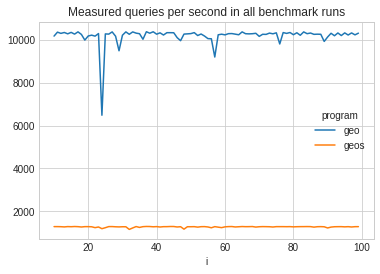

### Statistics: After outlier removal
                  qps             
program           geo         geos
count       84.000000    84.000000
mean     10254.699050  1270.318030
std        134.289497    12.519673
min       9498.522016  1224.413836
25%      10233.189104  1267.233221
50%      10288.524130  1275.060588
75%      10330.900051  1277.474848
max      10387.918103  1284.804230


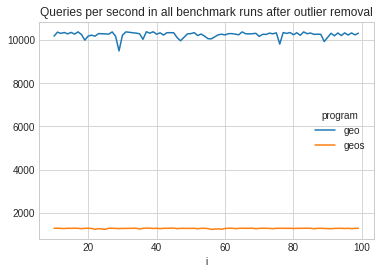

## Ratio of qps compared to geo
               qps
program       geos
count    84.000000
mean      0.123896
std       0.001928
min       0.119303
25%       0.122937
50%       0.123788
75%       0.124484
max       0.133136


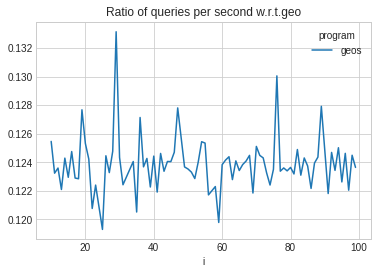

In [1]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb

# Performance benchmarking

To generate the following SVG:

```bash
cd harness
cargo build --release

perf record -F 100 -g --call-graph dwarf -o ../analysis/benchmark_area/perf.data -- ./target/release/benchmark_area --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 10 --headlong >/dev/null

cd ../analysis/benchmark_area
perf script -i perf.data | ../../third_party/stackcollapse-perf.pl > perf.collapsed-stacks.data
../../third_party/flamegraph.pl perf.collapsed-stacks.data > perf.svg
```

![](./perf.svg)

To dig in further, use
```
perf report -i perf.data --call-graph=fractal,0.5
```

Observations:
* Over 61% of the time is spent inside `geos::algorithm::Area::ofRingSigned` in libgeos.so - geos area computation proper
  * The descructor `geos::geom::CoordinateArraySequence::~CoordinateArraySequence` in the callgraph is a mystery
* Over 29% of the time is spent inside `geo::algorithm::area::get_linestring_area` -- geo area computation
* geos is *not* slow because of FFI.


# It's the vectors!

Vector iteration is 10x slower than Rust's iterators!

![](./geo_area.png)
![](./geos_area.png)